In [1]:
import sys, os

# Always go 1 level up from "transformation for use cases" to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
from loading.loader import write_to_mysql

spark = SparkSession.builder \
    .appName("Airport Traffic Monitor") \
    .getOrCreate()

parquet_path = "/Users/parthmac/Desktop/Projects/Flight Data Engineering/data/wrangled data/flattened_flight_data_parquet"
df = spark.read.parquet(parquet_path)

df.printSchema()
df.show(5, truncate=False)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/02 13:42:39 WARN Utils: Your hostname, Parths-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.249 instead (on interface en0)
25/09/02 13:42:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/02 13:42:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/02 13:42:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- aircraft_iata: string (nullable = true)
 |-- aircraft_icao: string (nullable = true)
 |-- aircraft_icao24: string (nullable = true)
 |-- aircraft_manufacturer: string (nullable = true)
 |-- aircraft_model: string (nullable = true)
 |-- aircraft_registration: string (nullable = true)
 |-- airline_iata: string (nullable = true)
 |-- airline_icao: string (nullable = true)
 |-- airline_name: string (nullable = true)
 |-- arrival_actual: string (nullable = true)
 |-- arrival_actual_runway: string (nullable = true)
 |-- arrival_airport: string (nullable = true)
 |-- arrival_baggage: string (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_estimated: string (nullable = true)
 |-- arrival_estimated_runway: string (nullable = true)
 |-- arrival_gate: string (nullable = true)
 |-- arrival_iata: string (nullable = true)
 |-- arrival_icao: string (nullable = true)
 |-- arrival_scheduled: string (nullable = true)
 |-- arrival_terminal: string (nullable = true)
 |--

25/09/02 13:42:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------+-------------+---------------+---------------------+--------------+---------------------+------------+------------+---------------+-------------------------+-------------------------+-----------------------------+---------------+-------------+-------------------------+-------------------------+------------+------------+------------+-------------------------+----------------+-------------------+-------------------------+-------------------------+-----------------------------------+---------------+-------------------------+--------------------------+--------------+--------------+--------------+-------------------------+------------------+------------------+------------------------------+------------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------+-----------+-------------+-----------+-------------+----+
|aircraft_iata|aircraft_icao|aircraft_icao24|aircraft_manufacturer|

In [2]:
traffic_df = df.select(
    F.col("flight_date").alias("date"),
    F.col("flight_status").alias("status"),

    F.col("departure_airport").alias("departure_airport_name"),
    F.col("departure_iata").alias("departure_airport_code"),
    F.col("departure_scheduled").alias("departure_time"),

    F.col("arrival_airport").alias("arrival_airport_name"),
    F.col("arrival_iata").alias("arrival_airport_code"),
    F.col("arrival_scheduled").alias("arrival_time"),

    F.col("airline_name").alias("airline"),
    F.col("airline_iata").alias("airline_code")
)

# Show preview
traffic_df.show(5, truncate=False)

+----------+---------+-----------------------------------+----------------------+-------------------------+-----------------------------+--------------------+-------------------------+---------------+------------+
|date      |status   |departure_airport_name             |departure_airport_code|departure_time           |arrival_airport_name         |arrival_airport_code|arrival_time             |airline        |airline_code|
+----------+---------+-----------------------------------+----------------------+-------------------------+-----------------------------+--------------------+-------------------------+---------------+------------+
|2025-08-30|cancelled|Stockholm Arlanda Airport          |ARN                   |2025-08-30T09:29:00+00:00|St. Petersburg Pulkovo       |LED                 |2025-08-30T14:29:00+00:00|IndiGo         |6E          |
|2025-08-30|landed   |Prague Václav Havel Airport        |PRG                   |2025-08-30T20:59:00+00:00|Doha International Airport   |DOH    

In [3]:
# Group by for departures and arrivals
departures = traffic_df.groupBy("date", "departure_airport_code", "departure_airport_name") \
    .agg(F.count("*").alias("departure_count")).alias("d")

arrivals = traffic_df.groupBy("date", "arrival_airport_code", "arrival_airport_name") \
    .agg(F.count("*").alias("arrival_count")).alias("a")

# Join with proper aliasing and qualified column references
traffic_per_airport = departures.join(
    arrivals,
    (F.col("d.date") == F.col("a.date")) &
    (F.col("d.departure_airport_code") == F.col("a.arrival_airport_code")),
    how="outer"
).select(
    F.coalesce(F.col("d.date"), F.col("a.date")).alias("date"),
    F.coalesce(F.col("d.departure_airport_code"), F.col("a.arrival_airport_code")).alias("airport_code"),
    F.coalesce(F.col("d.departure_airport_name"), F.col("a.arrival_airport_name")).alias("airport_name"),
    F.col("d.departure_count"),
    F.col("a.arrival_count")
).fillna(0)

# Show result
traffic_per_airport.orderBy("date", "airport_code").show(truncate=False)

+----------+------------+-------------------------------------------------+---------------+-------------+
|date      |airport_code|airport_name                                     |departure_count|arrival_count|
+----------+------------+-------------------------------------------------+---------------+-------------+
|2025-08-22|AGP         |Malaga Costa Del Sol Airport                     |123            |100          |
|2025-08-22|AKL         |Auckland Airport                                 |107            |115          |
|2025-08-22|ALA         |Almaty International Airport                     |105            |104          |
|2025-08-22|AMM         |Amman Queen Alia Intl                            |123            |107          |
|2025-08-22|AMS         |Amsterdam Schiphol Airport                       |116            |93           |
|2025-08-22|ARN         |Stockholm Arlanda Airport                        |114            |95           |
|2025-08-22|ATH         |Athens Eleftherios Ve

In [4]:
# Add a column for total traffic per airport
busiest_airport_df = traffic_per_airport.withColumn(
    "total_traffic", F.col("departure_count") + F.col("arrival_count")
)

# Define a window partitioned by date and ordered by traffic descending
window_spec = Window.partitionBy("date").orderBy(F.desc("total_traffic"))

# Add rank based on total traffic
ranked_df = busiest_airport_df.withColumn("dense_rank", F.row_number().over(window_spec))

# Filter top 3 airports per day
top_3_df = ranked_df.filter(F.col("dense_rank") <= 3)

# Optional: Select and rename columns
top_3_df = top_3_df.select(
    "date", "airport_code", "airport_name", "departure_count", "arrival_count", "total_traffic"
)

top_3_df.show(truncate=False)

+----------+------------+--------------------------------------+---------------+-------------+-------------+
|date      |airport_code|airport_name                          |departure_count|arrival_count|total_traffic|
+----------+------------+--------------------------------------+---------------+-------------+-------------+
|2025-08-22|AUH         |Abu Dhabi International Airport       |197            |226          |423          |
|2025-08-22|RUH         |Riyadh King Khalid Intl               |110            |128          |238          |
|2025-08-22|SZX         |Shenzhen Bao'an International         |129            |106          |235          |
|2025-08-23|AUH         |Abu Dhabi International Airport       |226            |200          |426          |
|2025-08-23|KWI         |Kuwait International Airport          |109            |125          |234          |
|2025-08-23|CAN         |Guangzhou Baiyun International Airport|117            |116          |233          |
|2025-08-24|AUH    

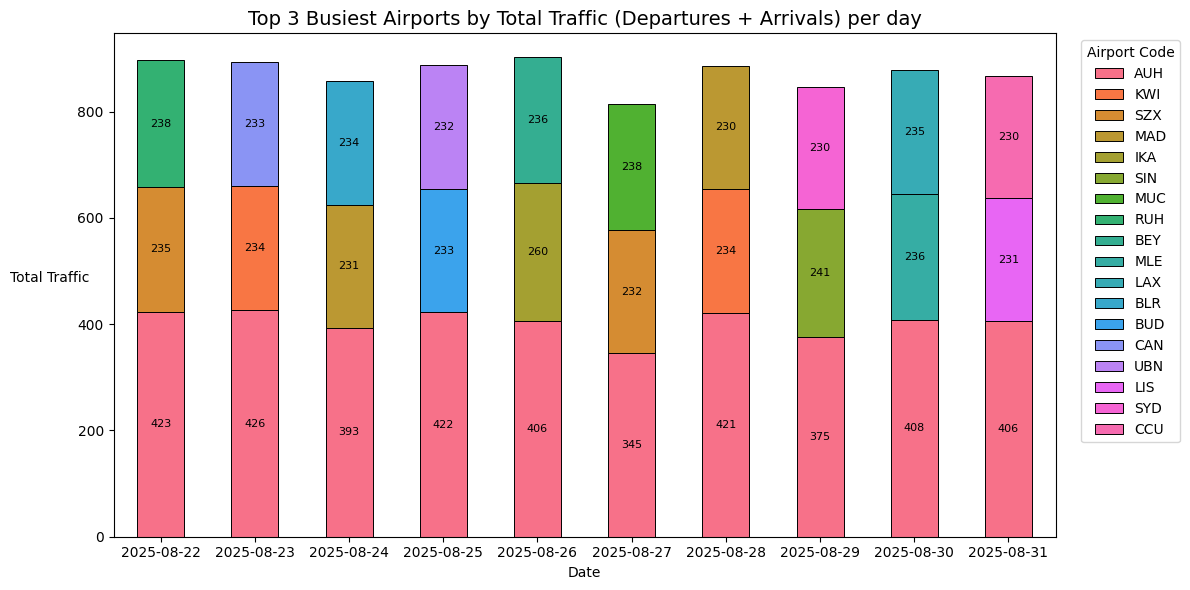

In [5]:
pdf = top_3_df.toPandas()

# Ensure sorting of airports by traffic within each day
pdf = pdf.sort_values(by=["date", "total_traffic"], ascending=[True, False])

# Pivot: rows = dates, cols = airport_code
pivot_df = (
    pdf.pivot(index="date", columns="airport_code", values="total_traffic")
       .fillna(0)
       .sort_index()
)

# Sort columns by total traffic sum (helps consistent order in legend)
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# --- Colors ---
num_codes = len(pivot_df.columns)
colors = sns.color_palette("husl", n_colors=num_codes)

# --- Stacked Bar Plot ---
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6), 
    color=colors, edgecolor="black", linewidth=0.7  # ✅ outline bars
)

ax.set_title("Top 3 Busiest Airports by Total Traffic (Departures + Arrivals) per day", fontsize=14)
ax.set_ylabel("Total Traffic", rotation=0, labelpad=20)
ax.set_xlabel("Date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Airport Code", bbox_to_anchor=(1.02, 1), loc="upper left")

# Add counts inside each stack segment
for container in ax.containers:
    labels = [f"{int(bar.get_height())}" if bar.get_height() > 0 else "" for bar in container]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.tight_layout()
plt.show()


In [6]:
# Top 3 by departure_count
w_departure = Window.partitionBy("date").orderBy(F.col("departure_count").desc())

top3_departure_df = (
    traffic_per_airport.withColumn("rank", F.row_number().over(w_departure))
      .filter(F.col("rank") <= 3)
      .drop("rank")
      .orderBy("date", F.col("departure_count").desc())
)

# Top 3 by arrival_count
w_arrival = Window.partitionBy("date").orderBy(F.col("arrival_count").desc())

top3_arrival_df = (
    traffic_per_airport.withColumn("rank", F.row_number().over(w_arrival))
      .filter(F.col("rank") <= 3)
      .drop("rank")
      .orderBy("date", F.col("arrival_count").desc())
)

top3_departure_df = top3_departure_df.select("date", "airport_code", "airport_name", "departure_count")
top3_departure_df.show(truncate=False)

+----------+------------+-------------------------------------+---------------+
|date      |airport_code|airport_name                         |departure_count|
+----------+------------+-------------------------------------+---------------+
|2025-08-22|AUH         |Abu Dhabi International Airport      |197            |
|2025-08-22|BLR         |Bangalore Kempegowda International   |131            |
|2025-08-22|SZX         |Shenzhen Bao'an International        |129            |
|2025-08-23|AUH         |Abu Dhabi International Airport      |226            |
|2025-08-23|PEK         |Beijing Capital International Airport|125            |
|2025-08-23|PER         |Perth Airport                        |122            |
|2025-08-24|AUH         |Abu Dhabi International Airport      |182            |
|2025-08-24|DXB         |Dubai International Airport          |121            |
|2025-08-24|MAD         |Madrid–Barajas Airport               |120            |
|2025-08-25|AUH         |Abu Dhabi Inter

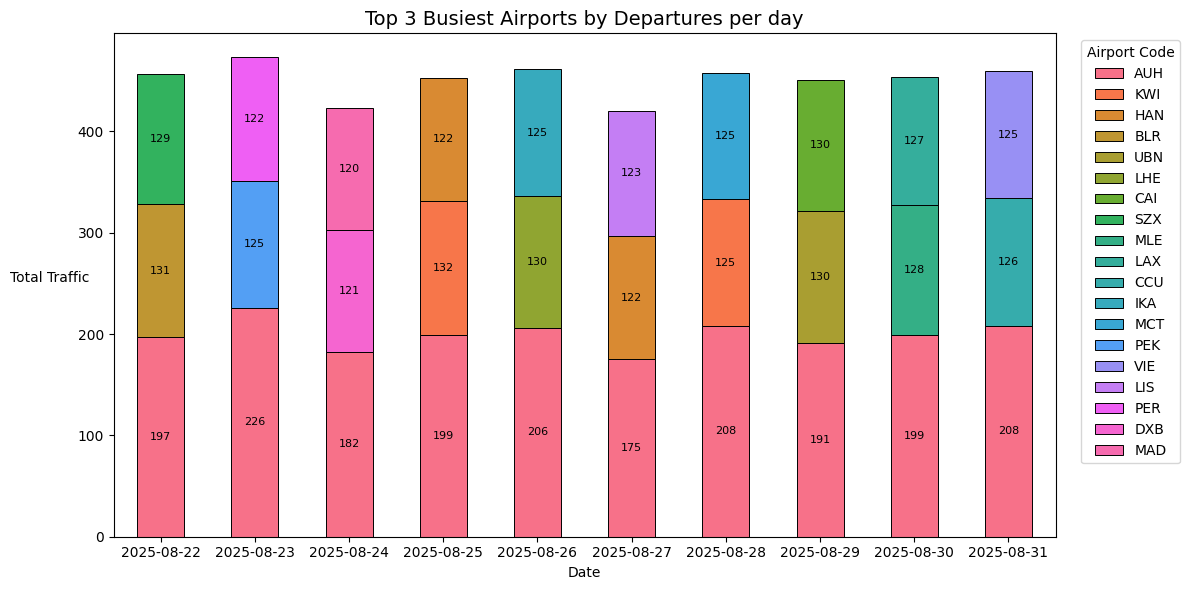

In [7]:
# Convert to Pandas
pdf = top3_departure_df.toPandas()

# Ensure sorting of airports by traffic within each day
pdf = pdf.sort_values(by=["date", "departure_count"], ascending=[True, False])

# Pivot: rows = dates, cols = airport_code
pivot_df = (
    pdf.pivot(index="date", columns="airport_code", values="departure_count")
       .fillna(0)
       .sort_index()
)

# Sort columns by total traffic sum (helps consistent order in legend)
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# --- Colors ---
num_codes = len(pivot_df.columns)
colors = sns.color_palette("husl", n_colors=num_codes)

# --- Stacked Bar Plot ---
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6), 
    color=colors, edgecolor="black", linewidth=0.7  # ✅ outline bars
)

ax.set_title("Top 3 Busiest Airports by Departures per day", fontsize=14)
ax.set_ylabel("Total Traffic", rotation=0, labelpad=20)
ax.set_xlabel("Date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Airport Code", bbox_to_anchor=(1.02, 1), loc="upper left")

# Add counts inside each stack segment
for container in ax.containers:
    labels = [f"{int(bar.get_height())}" if bar.get_height() > 0 else "" for bar in container]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.tight_layout()
plt.show()


In [8]:
top3_arrival_df = top3_arrival_df.select("date", "airport_code", "airport_name", "arrival_count")
top3_arrival_df.show(truncate=False)

+----------+------------+------------------------------------------------+-------------+
|date      |airport_code|airport_name                                    |arrival_count|
+----------+------------+------------------------------------------------+-------------+
|2025-08-22|AUH         |Abu Dhabi International Airport                 |226          |
|2025-08-22|RUH         |Riyadh King Khalid Intl                         |128          |
|2025-08-22|BCN         |Barcelona–El Prat Airport                       |121          |
|2025-08-23|AUH         |Abu Dhabi International Airport                 |200          |
|2025-08-23|DEN         |Denver International Airport                    |131          |
|2025-08-23|KWI         |Kuwait International Airport                    |125          |
|2025-08-24|AUH         |Abu Dhabi International Airport                 |211          |
|2025-08-24|BLR         |Bangalore Kempegowda International              |126          |
|2025-08-24|SIN      

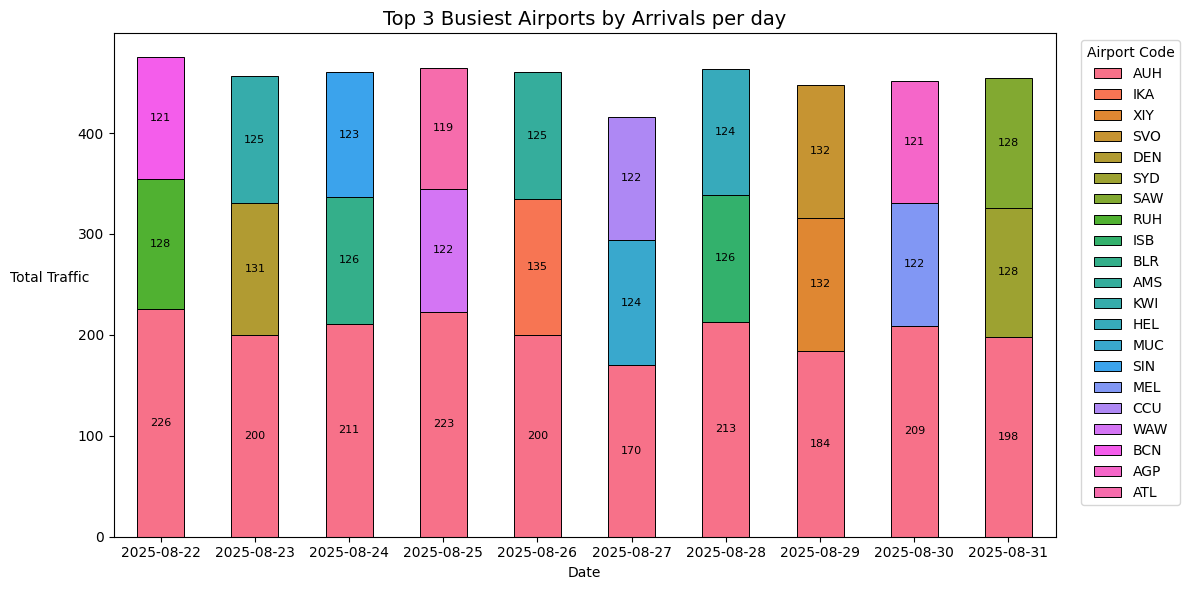

In [9]:
# Convert to Pandas
pdf = top3_arrival_df.toPandas()

# Ensure sorting of airports by traffic within each day
pdf = pdf.sort_values(by=["date", "arrival_count"], ascending=[True, False])

# Pivot: rows = dates, cols = airport_code
pivot_df = (
    pdf.pivot(index="date", columns="airport_code", values="arrival_count")
       .fillna(0)
       .sort_index()
)

# Sort columns by total traffic sum (helps consistent order in legend)
pivot_df = pivot_df[pivot_df.sum().sort_values(ascending=False).index]

# --- Colors ---
num_codes = len(pivot_df.columns)
colors = sns.color_palette("husl", n_colors=num_codes)

# --- Stacked Bar Plot ---
ax = pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6), 
    color=colors, edgecolor="black", linewidth=0.7  # ✅ outline bars
)

ax.set_title("Top 3 Busiest Airports by Arrivals per day", fontsize=14)
ax.set_ylabel("Total Traffic", rotation=0, labelpad=20)
ax.set_xlabel("Date")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Airport Code", bbox_to_anchor=(1.02, 1), loc="upper left")

# Add counts inside each stack segment
for container in ax.containers:
    labels = [f"{int(bar.get_height())}" if bar.get_height() > 0 else "" for bar in container]
    ax.bar_label(container, labels=labels, label_type="center", fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
#loading our dataframes to mysql after final transformations
write_to_mysql(top_3_df, "top_3_busiest_airports_daily", mode="overwrite")
write_to_mysql(top3_departure_df, "top_3_busiest_departure_airports_daily", mode="overwrite")
write_to_mysql(top3_arrival_df, "top_3_busiest_arrival_airports_daily", mode="overwrite")

✅ Data written to MySQL (localhost:3306/flight_db) → Table: top_3_busiest_airports_daily
✅ Data written to MySQL (localhost:3306/flight_db) → Table: top_3_busiest_departure_airports_daily
✅ Data written to MySQL (localhost:3306/flight_db) → Table: top_3_busiest_arrival_airports_daily
